# Classification and Feature Selection -- Random Forest
We use Random Forest for our binary classification of Lung Cancer. In particular, we will explore:
1. Variable Importance
1. Pruning (cost complexity)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from pprint import pprint

from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, RandomizedSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve

%matplotlib inline
plt.style.use('seaborn-white')

### 1. Understanding the data

In [3]:
lung_train = pd.read_csv("dataset/lung_training.csv")
lung_test = pd.read_csv("dataset/lung_test.csv")

In [4]:
lung_train.shape, lung_test.shape

((817, 17395), (205, 17395))

In [5]:
lung_train.columns # has DepMap_ID and label

Index(['DepMap_ID', 'A1BG..1.', 'A1CF..29974.', 'A2M..2.', 'A2ML1..144568.',
       'A3GALT2..127550.', 'A4GALT..53947.', 'A4GNT..51146.', 'AAAS..8086.',
       'AACS..65985.',
       ...
       'ZWINT..11130.', 'ZXDA..7789.', 'ZXDB..158586.', 'ZXDC..79364.',
       'ZYG11A..440590.', 'ZYG11B..79699.', 'ZYX..7791.', 'ZZEF1..23140.',
       'ZZZ3..26009.', 'label'],
      dtype='object', length=17395)

In [6]:
lung_test.columns # has DepMap_ID and label

Index(['DepMap_ID', 'A1BG..1.', 'A1CF..29974.', 'A2M..2.', 'A2ML1..144568.',
       'A3GALT2..127550.', 'A4GALT..53947.', 'A4GNT..51146.', 'AAAS..8086.',
       'AACS..65985.',
       ...
       'ZWINT..11130.', 'ZXDA..7789.', 'ZXDB..158586.', 'ZXDC..79364.',
       'ZYG11A..440590.', 'ZYG11B..79699.', 'ZYX..7791.', 'ZZEF1..23140.',
       'ZZZ3..26009.', 'label'],
      dtype='object', length=17395)

In [7]:
sum(lung_train.label == 1)/len(lung_train)

# only 12% of obs has labelled as lung cancer --> imbalanced class, thus need some more care
# Let us keep it as it is, later we will take the adjusted minority class with SMOTE

0.1175030599755202

In [8]:
X_train = lung_train.drop(['DepMap_ID', 'label'], axis = 1)
y_train = lung_train['label']

X_test = lung_test.drop(['DepMap_ID', 'label'], axis = 1)
y_test = lung_test['label']

### 2. Random Forest classifier

A Random Forest is an *ensemble* method, i.e. an approach that combines many simple methods. here classification trees, to obotain a single and more powerful one. In particular, Random Forests fit different decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy. 
The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default). If max_samples = n_features, then the whole dataset is used to build each tree and this is called Bagging.

___________________
Why not Bagging?

Primarly for two reasons:
1. our dataset is "too big", it is computationally onerous using all variables;
2. tree in bagging can be higly correlated.

___________________
What is *bootstrap*?

Each tree in the Random Forest learns from a random sample which is **drawn with replacement**. Thus, some samples can be used multiple times in a single tree.
In this situation, it can be shown that on average not all observation are used to fit the tree. Then, the idea is to use these remaing observations, known as *out-of-bag* obs, for quickly estimating the generalization accuracy. An oob error estimate is almost identical to that obtained by k-fold cv. Unlike many other nonlinear estimators, random forests can be fit in one sequence, with cross-validation being performed along the way.

___________________
What is *class_weight*?

Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. 

The *balanced* mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

The *balanced_subsample* mode is the same as balanced except that weights are computed based on the bootstrap sample for every tree grown.

___________________
Why we do not prune Random Forests?

Roughly speaking, some of the potential over-fitting that might happen in a single tree (which is a reason you do pruning generally) is mitigated because:
* bootstrap samples are used to train the individual trees;
* we have a multitude of random trees using random features and thus the individual trees are strong but not so correlated with each other.

___________________
___________________
Imbalance dataset, weighted class, NO pruning. We start by specifying a few parameters: n_estimators (since deafult is 100), bootstrap, oob_score and class_weight (since we already know we have an imbalaced class)

In [9]:
rf = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                    n_estimators = 500, class_weight = "balanced_subsample",
                    bootstrap = True, oob_score = True)

In [10]:
rf.fit(X_train, y_train)
print('Training score: ', rf.score(X_train, y_train))
print('Test score: ', rf.score(X_test, y_test))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training score:  1.0
Test score:  0.8536585365853658


We see that the Training score is perfect and the Test score is also high. It seems a good result.
To be sure about it, let us plot both the confusion matrix and the ROC curve.

In [11]:
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)
print(f'The accuracy of the model is {round(accuracy_score(y_test, y_pred), 3)*100} %')

print(f'Predicted {y_pred.sum()} obs out of {y_test.sum()} True obs')

The accuracy of the model is 85.39999999999999 %
Predicted 0 obs out of 30 True obs


In [12]:
# Confusion matrix
def plot_confusion_matrix(cm, classes, normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Oranges):

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                fontsize = 20,
                horizontalalignment = "center",
                color = "white" if cm[i, j] > thresh else "black")
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', size = 18)
        plt.xlabel('Predicted label', size = 18)

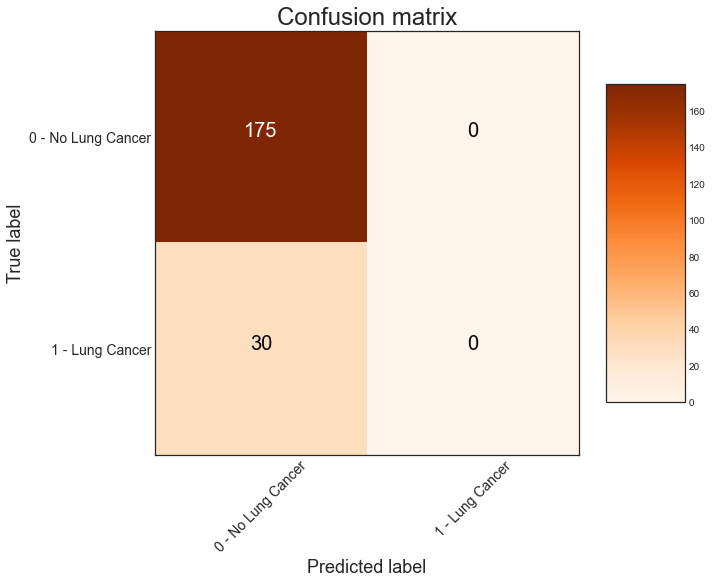

In [13]:
# Let us plot it
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['0 - No Lung Cancer', '1 - Lung Cancer'])

As we can see, our classifier has not detect the minority class: none of the Lung-cancer obs has been correctly classified.

In fact, we see that the Test score is about 85%, which is the ratio of Lung-cancer cells. Let us now plot the ROC curve and then continue in improving our RF classifier.

In [14]:
# ROC curve plot

def evaluate_model(y_pred, y_test, probs, y_train, train_predictions, train_probs):
    baseline = {}
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    results['recall'] = recall_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} - Test: {round(results[metric], 2)}, Train: {round(train_results[metric], 2)}')

    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16

    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'k--', label = 'Baseline')
    plt.plot(model_fpr, model_tpr, 'tab:orange', label = 'Model')
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves')
    plt.show()

In [15]:
train_predictions = rf.predict(X_train)
train_probs = rf.predict_proba(X_train)[:, 1]
probs = rf.predict_proba(X_test)[:, 1]

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC Score: {roc_auc_score(y_test, probs)}')

Train ROC AUC Score: 1.0
Test ROC AUC Score: 0.7325714285714285


Recall Baseline: 1.0 - Test: 0.0, Train: 1.0
Precision Baseline: 0.15 - Test: 0.0, Train: 1.0
Roc Baseline: 0.5 - Test: 0.73, Train: 1.0


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


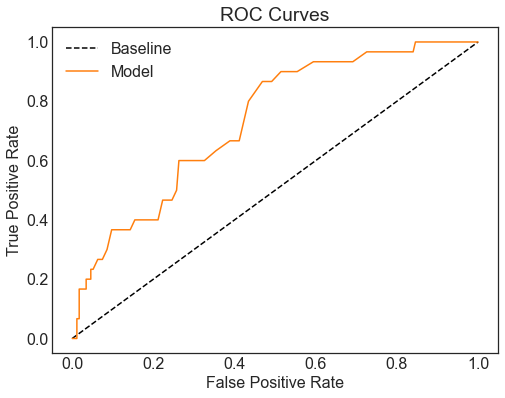

In [16]:
evaluate_model(y_pred, y_test, probs, y_train, train_predictions, train_probs)

As mentioned above, our RF classifier is not perfoming well on the minority class. So, let us use random grid to select the best model, based on the ROC_AUC score, hence scoring = 'roc_auc'.

In [30]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 700, num = 50)]
max_features = ['auto', 'log2']  # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(2, 68, num = 11)]   # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10]  # Minimum number of samples required to split a node
min_samples_leaf = [4, 10, 25, 50]    # Minimum number of samples required at each leaf node

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': [None] + list(np.linspace(10, 50, 200).astype(int))}

rf_cl = RandomForestClassifier(n_jobs = -1, class_weight = "balanced_subsample",
                    bootstrap = True, oob_score = True)

rf_random = RandomizedSearchCV(
                estimator = rf_cl,
                param_distributions = random_grid,
                cv = 5, n_iter = 2, # 50
                verbose = 1, random_state = 2311, 
                scoring = 'roc_auc')

In [31]:
# Finally, fit the data
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: 

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                    n_jobs=-1, oob_score=True),
                   n_iter=2,
                   param_distributions={'max_depth': [2, 8, 15, 21, 28, 35, 41,
                                                      48, 54, 61, 68, None],
                                        'max_features': ['auto', 'log2'],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 11, 11, 11, 11,
                                                           11, 12, 12, 12, 12,
                                                           12, 13, 13, 13, 13,
                                                           13, 14, 14, 14, 14,
                                                           14, 15, 15, 15, 15, ...],
                                        'min_samples_leaf': [4, 10

In [32]:
rf_random.cv_results_

{'mean_fit_time': array([59.34864392, 22.89470534]),
 'std_fit_time': array([5.61136566, 5.96333313]),
 'mean_score_time': array([0.39970303, 0.290273  ]),
 'std_score_time': array([0.01838528, 0.00658621]),
 'param_n_estimators': masked_array(data=[393, 100],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[10, 5],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[50, 25],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_leaf_nodes': masked_array(data=[42, 48],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=['log2', 'auto'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[28, 15],
              mask=[False, False],

In [33]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 25,
 'max_leaf_nodes': 48,
 'max_features': 'auto',
 'max_depth': 15}

We use this information to decide parameters of the new RF classifier.

In [39]:
rf = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                    n_estimators = 200, max_depth = 15,
                    min_samples_split = 25, min_samples_leaf = 30,
                    class_weight = "balanced_subsample",
                    bootstrap = True, oob_score = True)

In [40]:
rf.fit(X_train, y_train)
print('Training score: ', rf.score(X_train, y_train))
print('Test score: ', rf.score(X_test, y_test))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training score:  0.9975520195838433
Test score:  0.8536585365853658


The accuracy of the model is 85.39999999999999 %
Predicted 0 obs out of 30 True obs


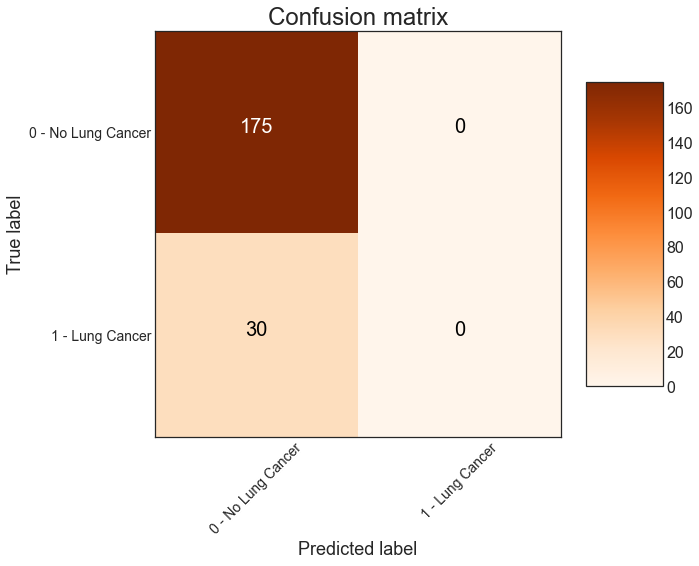

In [41]:
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)
print(f'The accuracy of the model is {round(accuracy_score(y_test, y_pred), 3)*100} %')

print(f'Predicted {y_pred.sum()} obs out of {y_test.sum()} True obs')

plot_confusion_matrix(confusion_matrix(y_test, y_pred),
                classes = ['0 - No Lung Cancer', '1 - Lung Cancer'])

Still no improvement. Let us see whether this moldel could bring a better classification

In [44]:
# 5-Fold Cross validation to validate the model
print(f'The mean cross validation score is: {np.mean(cross_val_score(rf, X_train, y_train, cv = 5))}')

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: 

The mean cross validation score is: 0.8812808618883736


It seems we cannot build a better RF classifier with the current dataset, hence we take the adjusted traing dataset t for the minority class.

### 3. Random Forest for Balanced dataset

In [45]:
lung_train = pd.read_csv("dataset/lung_training_balanced.csv")

X_train = lung_train.drop(['label', 'class'], axis = 1)
y_train = lung_train['label']

sum(lung_train.label == 1)/len(lung_train)

# 21% of obs has labelled as lung cancer

0.21029572836801752

In [46]:
# and grid search for optimal parameters
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: 

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                    n_jobs=-1, oob_score=True),
                   n_iter=2,
                   param_distributions={'max_depth': [2, 8, 15, 21, 28, 35, 41,
                                                      48, 54, 61, 68, None],
                                        'max_features': ['auto', 'log2'],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 11, 11, 11, 11,
                                                           11, 12, 12, 12, 12,
                                                           12, 13, 13, 13, 13,
                                                           13, 14, 14, 14, 14,
                                                           14, 15, 15, 15, 15, ...],
                                        'min_samples_leaf': [4, 10

In [47]:
rf_random.cv_results_

{'mean_fit_time': array([71.96987691, 22.40251188]),
 'std_fit_time': array([10.89091378,  2.64154964]),
 'mean_score_time': array([0.67496271, 0.32608504]),
 'std_score_time': array([0.24331576, 0.10520362]),
 'param_n_estimators': masked_array(data=[393, 100],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[10, 5],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[50, 25],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_leaf_nodes': masked_array(data=[42, 48],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=['log2', 'auto'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[28, 15],
              mask=[False, False

In [48]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 25,
 'max_leaf_nodes': 48,
 'max_features': 'auto',
 'max_depth': 15}

In [71]:
rf_bal = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                    n_estimators = 300, 
                    min_samples_split = 20, min_samples_leaf = 50,
                    max_depth = 40, class_weight = "balanced_subsample",
                    bootstrap = True, oob_score = True)

rf_bal.fit(X_train, y_train)
print('Training score: ', rf_bal.score(X_train, y_train))
print('Test score: ', rf_bal.score(X_test, y_test))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training score:  0.976998904709748
Test score:  0.848780487804878


The accuracy of the model is 84.89999999999999 %
Predicted 5 obs out of 30 True obs


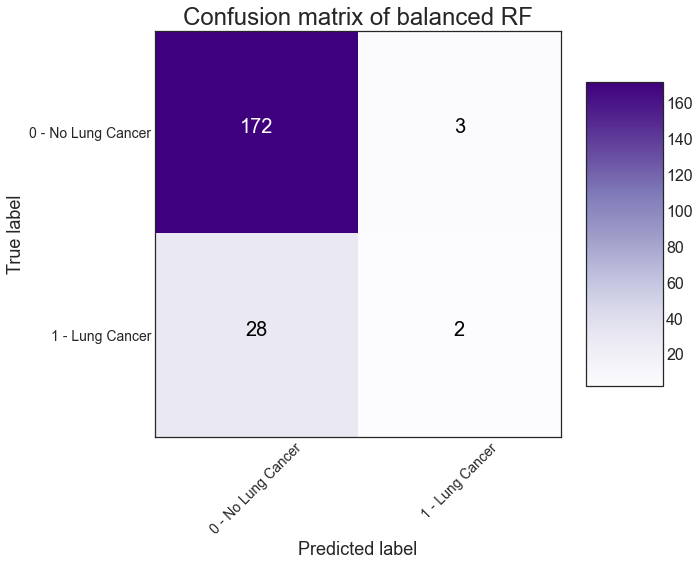

In [72]:
y_pred = rf_bal.predict(X_test)
accuracy_score(y_test, y_pred)
print(f'The accuracy of the model is {round(accuracy_score(y_test, y_pred), 3)*100} %')

print(f'Predicted {y_pred.sum()} obs out of {y_test.sum()} True obs')

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,
        classes = ['0 - No Lung Cancer', '1 - Lung Cancer'],
        title = 'Confusion matrix of balanced RF',
        cmap = plt.cm.Purples)

# Slightly better: it cannot predict correctly,
# but at least now it is able to detect the minority class

In [74]:
# Let us see the general performance of this model:
print(f'The mean cross validation score is: {np.mean(cross_val_score(rf_bal, X_train, y_train, cv = 5))}')

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: 

The mean cross validation score is: 0.9081126523749475


Train ROC AUC Score: 0.9984830097087379
Test ROC AUC Score: 0.6960000000000002
Recall Baseline: 1.0 - Test: 0.07, Train: 0.9
Precision Baseline: 0.15 - Test: 0.4, Train: 0.99
Roc Baseline: 0.5 - Test: 0.7, Train: 1.0


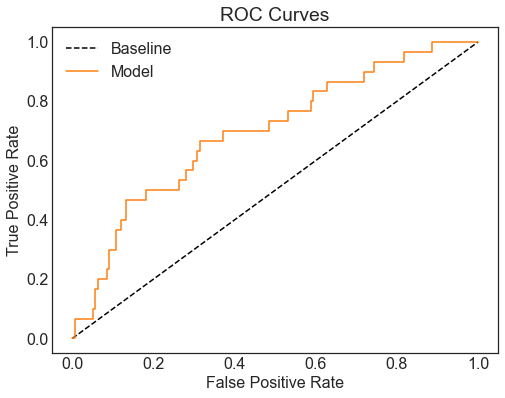

In [75]:
train_predictions = rf_bal.predict(X_train)
train_probs = rf_bal.predict_proba(X_train)[:, 1]
probs = rf_bal.predict_proba(X_test)[:, 1]

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC Score: {roc_auc_score(y_test, probs)}')

evaluate_model(y_pred, y_test, probs, y_train, train_predictions, train_probs)

### 4. Pruned Random Forest classifier
Imbalance dataset, weighted class.

Looking at the documentation of RandomForestClassifier, we see the attribute *ccp_alpha* (non-negative float, default = 0.0).

This is the complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. By default, no pruning is performed.

Let us try it to see if the situation gets better

In [76]:
rf_pruned = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                    ccp_alpha = 0.001, n_estimators = 300,
                    min_samples_split = 20, min_samples_leaf = 40,
                    max_depth = 40, class_weight = "balanced_subsample",
                    bootstrap = True, oob_score = True)

rf_pruned.fit(X_train, y_train)
print('Training score: ', rf_pruned.score(X_train, y_train))
print('Test score: ', rf_pruned.score(X_test, y_test))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training score:  0.9791894852135816
Test score:  0.8439024390243902


The accuracy of the model is 84.39999999999999 %
Predicted 2 obs out of 30 True obs


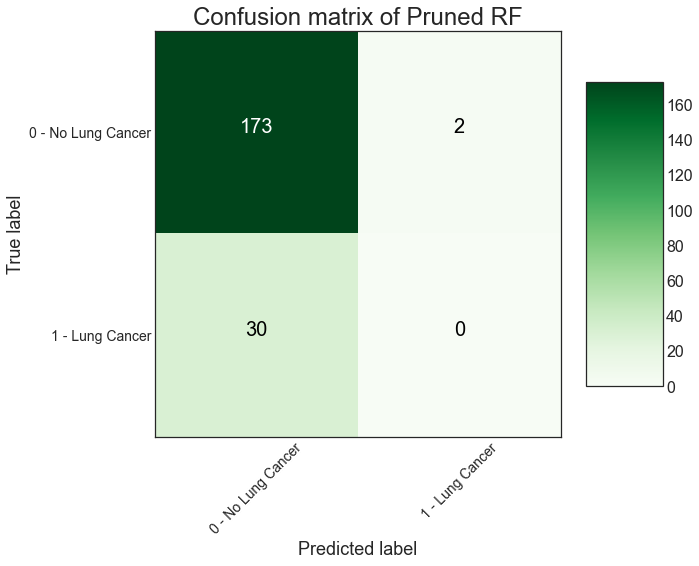

In [77]:
y_pred = rf_pruned.predict(X_test)
accuracy_score(y_test, y_pred)
print(f'The accuracy of the model is {round(accuracy_score(y_test, y_pred), 3)*100} %')

print(f'Predicted {y_pred.sum()} obs out of {y_test.sum()} True obs')

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,
        classes = ['0 - No Lung Cancer', '1 - Lung Cancer'],
        title = 'Confusion matrix of Pruned RF',
        cmap = plt.cm.Greens)

In [79]:
# Let us try a 3-fold cv for finding the optimal alpha
ccp_alpha = [float(x) for x in np.linspace(start = 0.00005, stop = 0.001, num = 75)]
max_depth = [int(x) for x in np.linspace(2, 50, num = 15)]   # Maximum number of levels in tree
max_depth.append(None)

random_grid = {'ccp_alpha': ccp_alpha,
               'max_depth': max_depth}

# First create a base model: 
rf_cl = RandomForestClassifier(n_estimators = 300, min_samples_leaf = 40,
                        min_samples_split = 20, max_leaf_nodes = 48,
                        class_weight = "balanced_subsample",
                        bootstrap = True, oob_score = True, n_jobs = -1)

# Then, use random grid to select the best model, based on the ROC_AUC score, hence scoring = 'roc_auc'
rf_random = RandomizedSearchCV(
                    estimator = rf_cl,
                    param_distributions = random_grid,
                    n_iter = 2, cv = 3,
                    verbose = 1, random_state = 2311, 
                    scoring = 'roc_auc')

In [80]:
# Finally, fit the data
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: 

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                    max_leaf_nodes=48,
                                                    min_samples_leaf=40,
                                                    min_samples_split=20,
                                                    n_estimators=300, n_jobs=-1,
                                                    oob_score=True),
                   n_iter=2,
                   param_distributions={'ccp_alpha': [5e-05,
                                                      6.283783783783784e-05,
                                                      7.567567567567568e-05,
                                                      8.851351351351352e-05,
                                                      0.00010135135135135135,
                                                      0.00011418918918918...
                                            

In [81]:
rf_random.best_params_

# Note that it chooses one of the two extremes of max_dept

{'max_depth': 50, 'ccp_alpha': 0.0009486486486486486}

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training score:  0.976998904709748
Test score:  0.8536585365853658


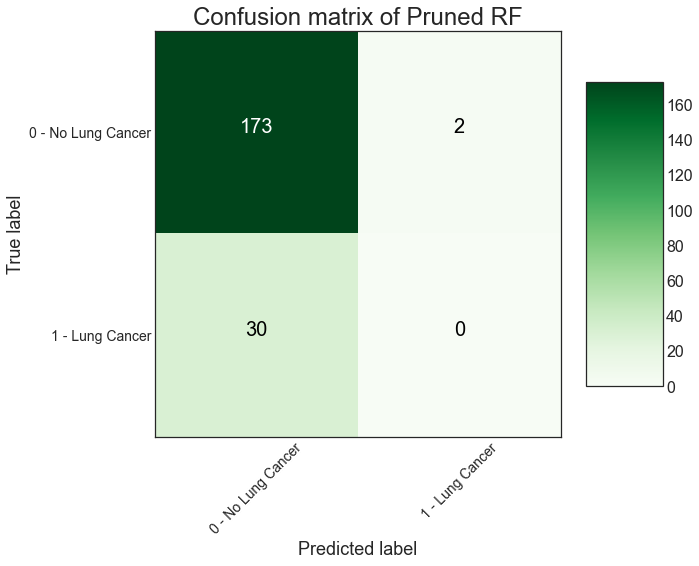

In [85]:
rf_pruned_best = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                        ccp_alpha = 0.00095,
                        n_estimators = 300, min_samples_leaf = 40,
                        min_samples_split = 20, max_leaf_nodes = 48,
                        class_weight = "balanced_subsample", max_depth = 55,
                        bootstrap = True, oob_score = True)

rf_pruned_best.fit(X_train, y_train)
print('Training score: ', rf_pruned_best.score(X_train, y_train))
print('Test score: ', rf_pruned_best.score(X_test, y_test))

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,
        classes = ['0 - No Lung Cancer', '1 - Lung Cancer'],
        title = 'Confusion matrix of Pruned RF',
        cmap = plt.cm.Greens)

In [86]:
print(f'The mean cross validation score is: {np.mean(cross_val_score(rf_pruned_best, X_train, y_train, cv = 5))}')

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: 

The mean cross validation score is: 0.914688044196241


### 5. Last try
Fit k = 100 tree as in bagging but on balanced dataset

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier

In [ ]:
models = []

for i in range(100):
    # create random undersampling of majority class
    rus = RandomUnderSampler(random_state = i)
    X_res, y_res = rus.fit_resample(X_train, y_train)

    model_i = DecisionTreeClassifier()
    model_i = model_i.fit(X_res, y_res)

    models.append(model_i)

In [ ]:
sum_pred = 0
for i in range(len(models)):
    sum_pred += models[i].predict(X_test)

ensemble_prediction = (sum_pred/len(models)) > 0.5

cm = confusion_matrix(y_test, ensemble_prediction)
plot_confusion_matrix(cm,
        classes = ['0 - No Lung Cancer', '1 - Lung Cancer'],
        title = 'Confusion matrix of Bagging',
        cmap = plt.cm.Pinks)

### 6. Feature Importance
We have tried different models and the best one is without cost complexity parameter for the balanced dataset: *rf_bal*.

REM: it reached about 91% of score in 5-fold cross validation and it has dectected the minority class.

Even if probably does not make any sense to persue with this classification, our initial aim is to identify the most relevant features, so that we can remove unnecessary features from the data to reduce noise.
To this end, we will perform a 5-fold cross validation. The idea is to get the feature importance values from each of the 5 models built in the 5-fold cross-validation and then take the average of the 5 importance values for each feature in order to select the top N features for the final model.

In [88]:
rf = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                n_estimators = 300,
                min_samples_split = 20, min_samples_leaf = 50,
                max_depth = 40, class_weight = "balanced_subsample",
                bootstrap = True, oob_score = True)

out = cross_validate(rf, X_train, y_train, cv = 5, n_jobs = -1,
                scoring = 'accuracy', return_estimator = True)

In [89]:
feat_impo_all = []
for i, estimator in enumerate(out['estimator']):
    print("First 10 features sorted by their importance for model n. {}:".format(i+1))
    feat_impo = pd.DataFrame(estimator.feature_importances_,
                            index = X_train.columns,
                            columns = ['Importance{}'.format(i+1)]).sort_values('Importance{}'.format(i+1), ascending = False)
    print(feat_impo[:10])
    print('--------------------------------------------------------------')

    feat_impo_all.append(feat_impo[feat_impo['Importance{}'.format(i+1)] > 0.001])

First 10 features sorted by their importance for model n. 1:
                  Importance1
CCT4..10575.         0.012977
HIST1H2BE..8344.     0.009824
RPP25L..138716.      0.008715
LEXM..163747.        0.006887
POLR3K..51728.       0.006765
CYB5A..1528.         0.006336
LUC7L3..51747.       0.006131
SF3A2..8175.         0.005209
DUPD1..338599.       0.005074
RAB18..22931.        0.005060
--------------------------------------------------------------
First 10 features sorted by their importance for model n. 2:
                 Importance2
CCT4..10575.        0.011387
RPP25L..138716.     0.008187
CYB5A..1528.        0.006557
GARS..2617.         0.006467
POLR3K..51728.      0.005502
FANCB..2187.        0.005164
DNAJC6..9829.       0.005094
IFNE..338376.       0.004971
RAB18..22931.       0.004866
HIST1H4E..8367.     0.004710
--------------------------------------------------------------
First 10 features sorted by their importance for model n. 3:
                  Importance3
LEXM..163747

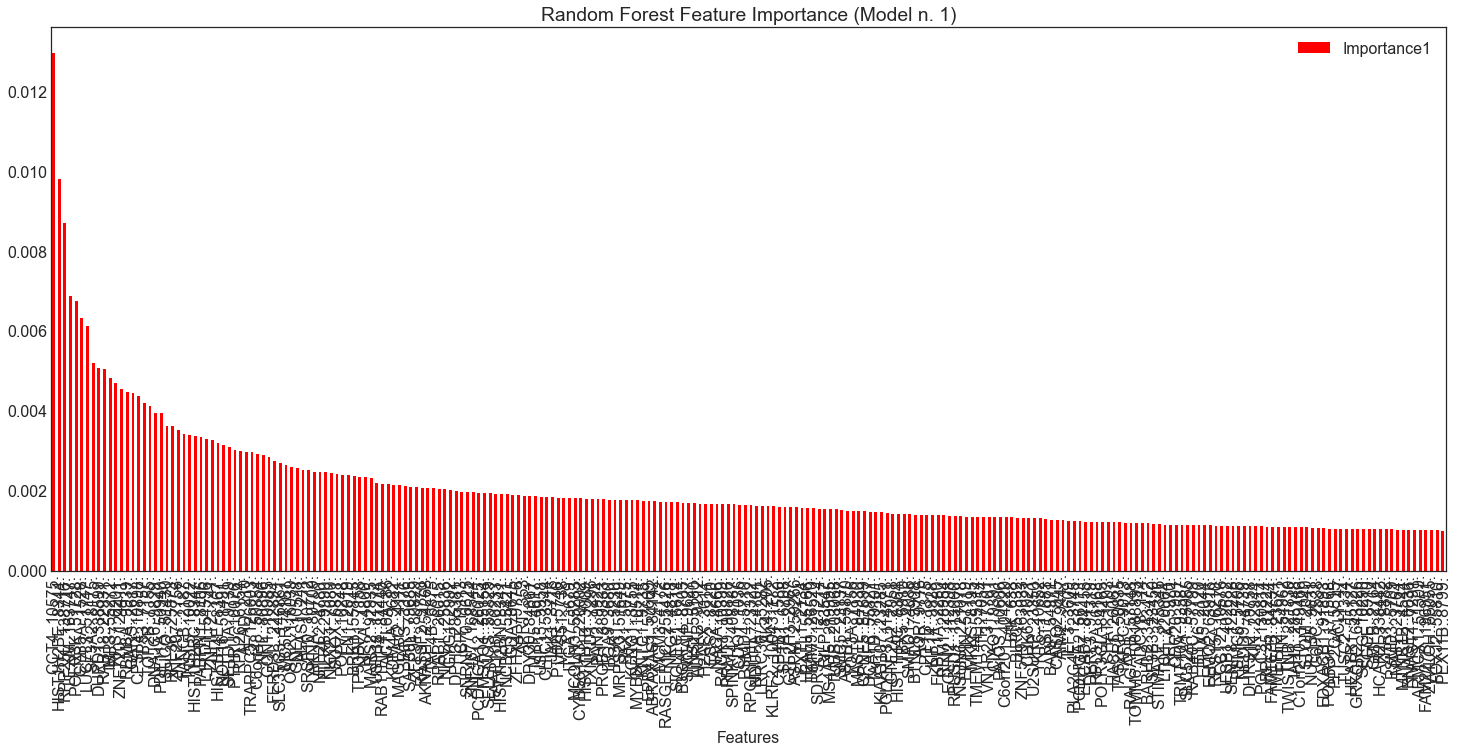

In [90]:
feat_impo_all[0].plot.bar(figsize = (25, 10), color = 'r')
plt.title('Random Forest Feature Importance (Model n. 1)')
plt.xlabel('Features')
plt.show()

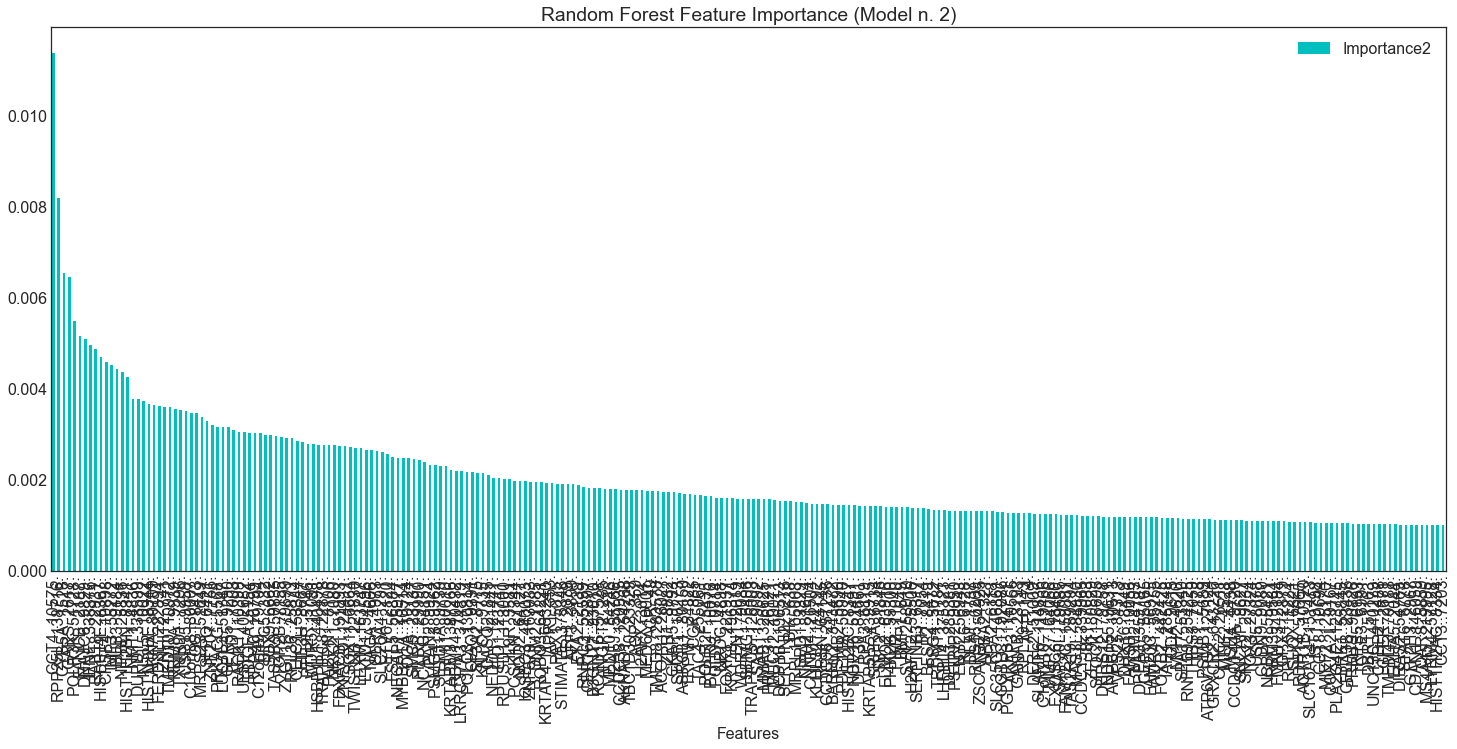

In [91]:
feat_impo_all[1].plot.bar(figsize = (25, 10), color = 'c')
plt.title('Random Forest Feature Importance (Model n. 2)')
plt.xlabel('Features')
plt.show()

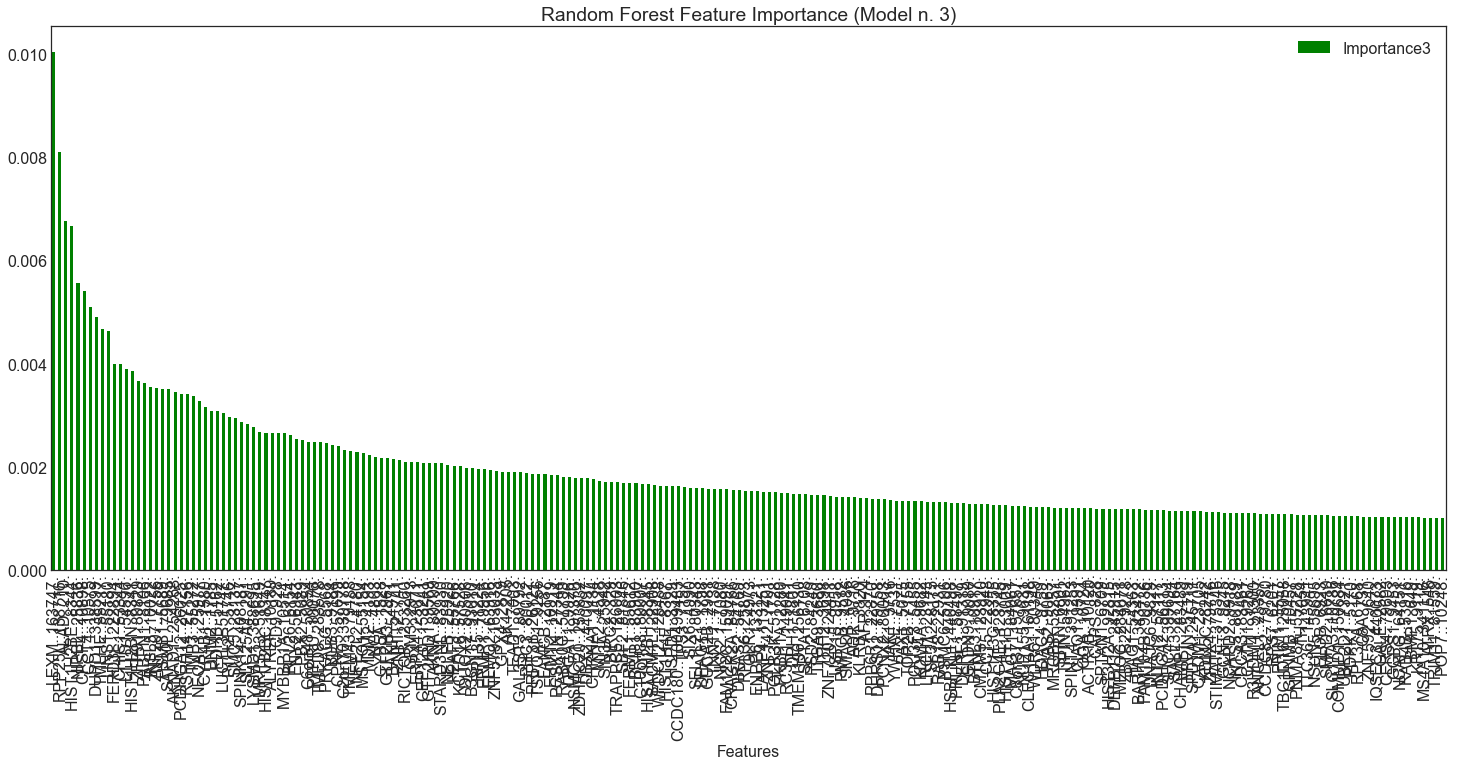

In [92]:
feat_impo_all[2].plot.bar(figsize = (25, 10), color = 'g')
plt.title('Random Forest Feature Importance (Model n. 3)')
plt.xlabel('Features')
plt.show()

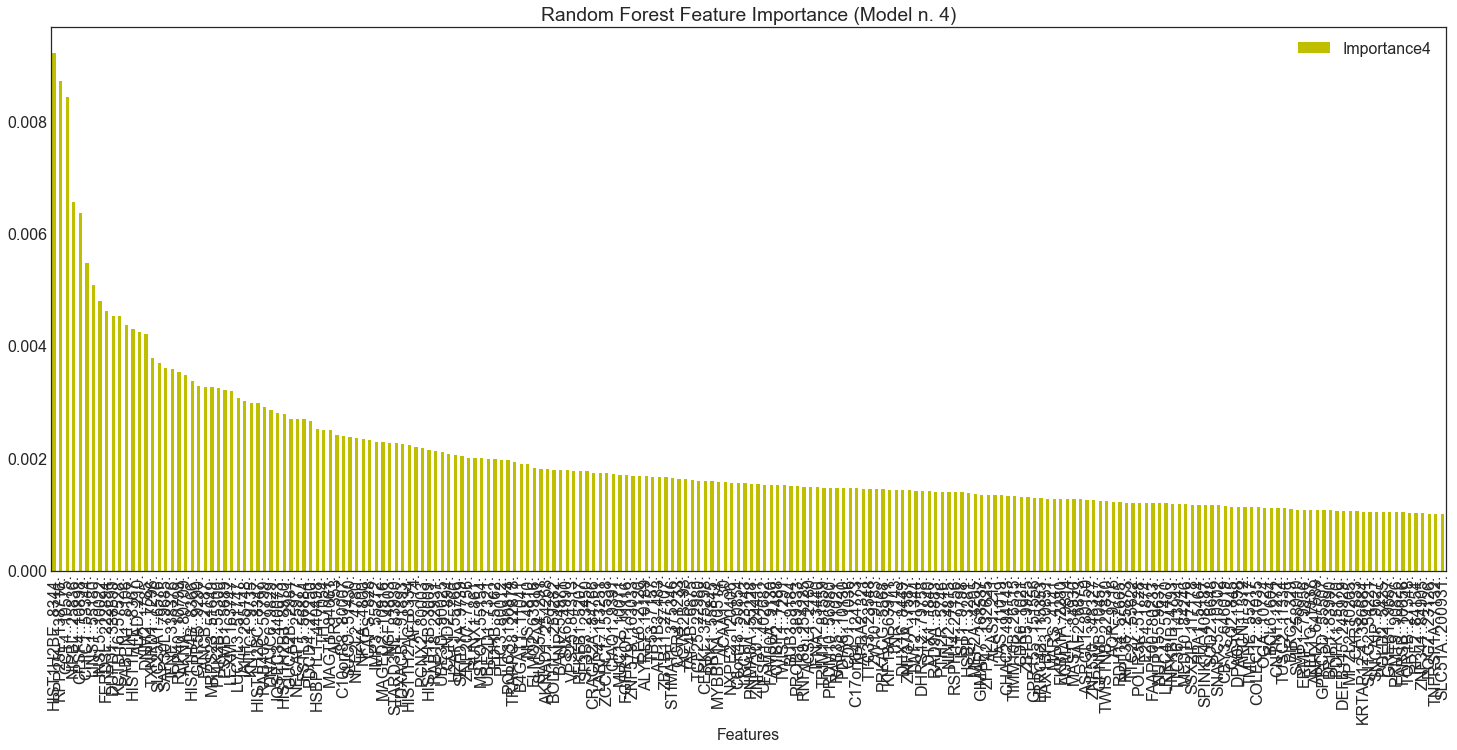

In [93]:
feat_impo_all[3].plot.bar(figsize = (25, 10), color = 'y')
plt.title('Random Forest Feature Importance (Model n. 4)')
plt.xlabel('Features')
plt.show()

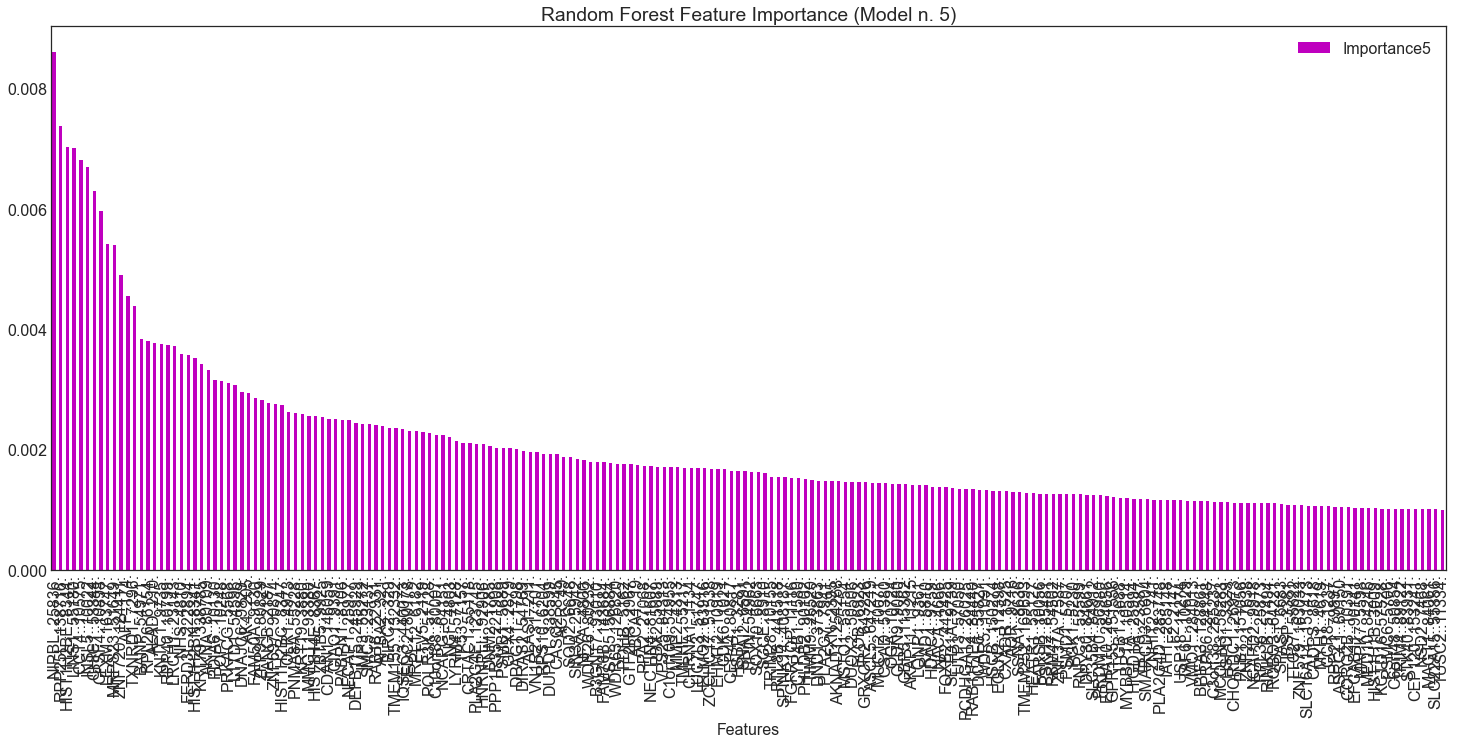

In [94]:
feat_impo_all[4].plot.bar(figsize = (25, 10), color = 'm')
plt.title('Random Forest Feature Importance (Model n. 5)')
plt.xlabel('Features')
plt.show()

In [95]:
df0 = pd.DataFrame(feat_impo_all[0])
df1 = pd.DataFrame(feat_impo_all[1])
df2 = pd.DataFrame(feat_impo_all[2])
df3 = pd.DataFrame(feat_impo_all[3])
df4 = pd.DataFrame(feat_impo_all[4])

In [96]:
most_feat_impo = pd.concat([df0, df1, df2, df3, df4], axis = 1)
most_feat_impo

,Importance1,Importance2,Importance3,Importance4,Importance5
CCT4..10575.,0.012977,0.011387,0.005096,0.008444,0.006815
HIST1H2BE..8344.,0.009824,0.003662,0.006665,0.009230,0.007028
RPP25L..138716.,0.008715,0.008187,0.008105,0.008728,0.007374
LEXM..163747.,0.006887,0.002704,0.010039,0.003210,0.005418
POLR3K..51728.,0.006765,0.005502,0.001503,0.001206,0.002269
...,...,...,...,...,...
MAPK7..5598.,NaN,NaN,NaN,NaN,0.001030
TRIM4..89122.,NaN,NaN,NaN,NaN,0.001014
STK40..83931.,NaN,NaN,NaN,NaN,0.001013
NSD2..7468.,NaN,NaN,NaN,NaN,0.001010


In [97]:
most_feat_impo = most_feat_impo.dropna()
most_feat_impo['Importance_mean'] = most_feat_impo.mean(axis = 1)
most_feat_impo

<ipython-input-97-2789dce5513e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_feat_impo['Importance_mean'] = most_feat_impo.mean(axis = 1)


,Importance1,Importance2,Importance3,Importance4,Importance5,Importance_mean
CCT4..10575.,0.012977,0.011387,0.005096,0.008444,0.006815,0.008944
HIST1H2BE..8344.,0.009824,0.003662,0.006665,0.009230,0.007028,0.007282
RPP25L..138716.,0.008715,0.008187,0.008105,0.008728,0.007374,0.008222
LEXM..163747.,0.006887,0.002704,0.010039,0.003210,0.005418,0.005652
POLR3K..51728.,0.006765,0.005502,0.001503,0.001206,0.002269,0.003449
LUC7L3..51747.,0.006131,0.003163,0.003037,0.003079,0.001697,0.003421
DUPD1..338599.,0.005074,0.003777,0.004902,0.004538,0.001932,0.004045
RAB18..22931.,0.005060,0.004866,0.001314,0.002133,0.002405,0.003155
IMP3..55272.,0.004822,0.004528,0.003361,0.002292,0.002434,0.003487
ZNF720..124411.,0.004551,0.002740,0.001429,0.001538,0.004905,0.003033


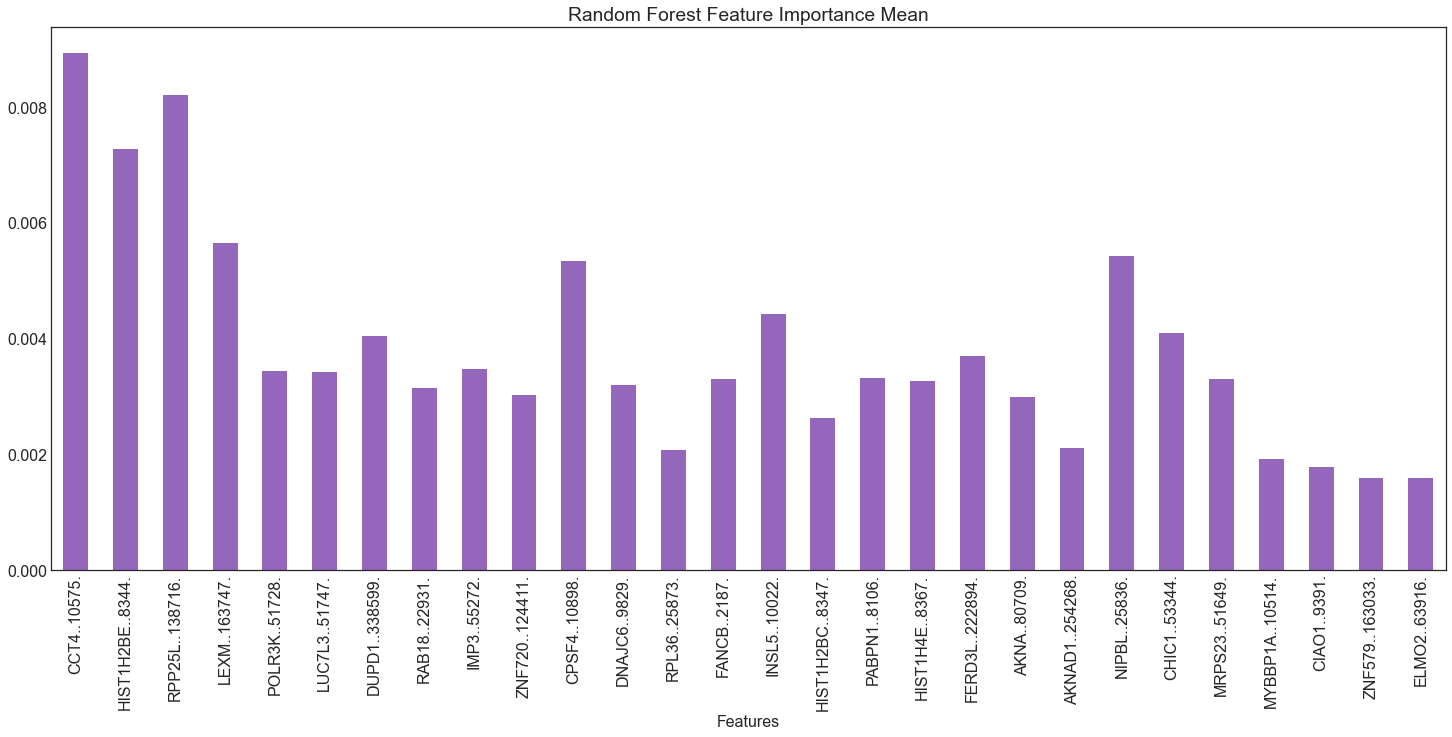

In [98]:
most_feat_impo.Importance_mean.plot.bar(figsize = (25, 10), color = 'tab:purple')
plt.title('Random Forest Feature Importance Mean')
plt.xlabel('Features')
plt.show()

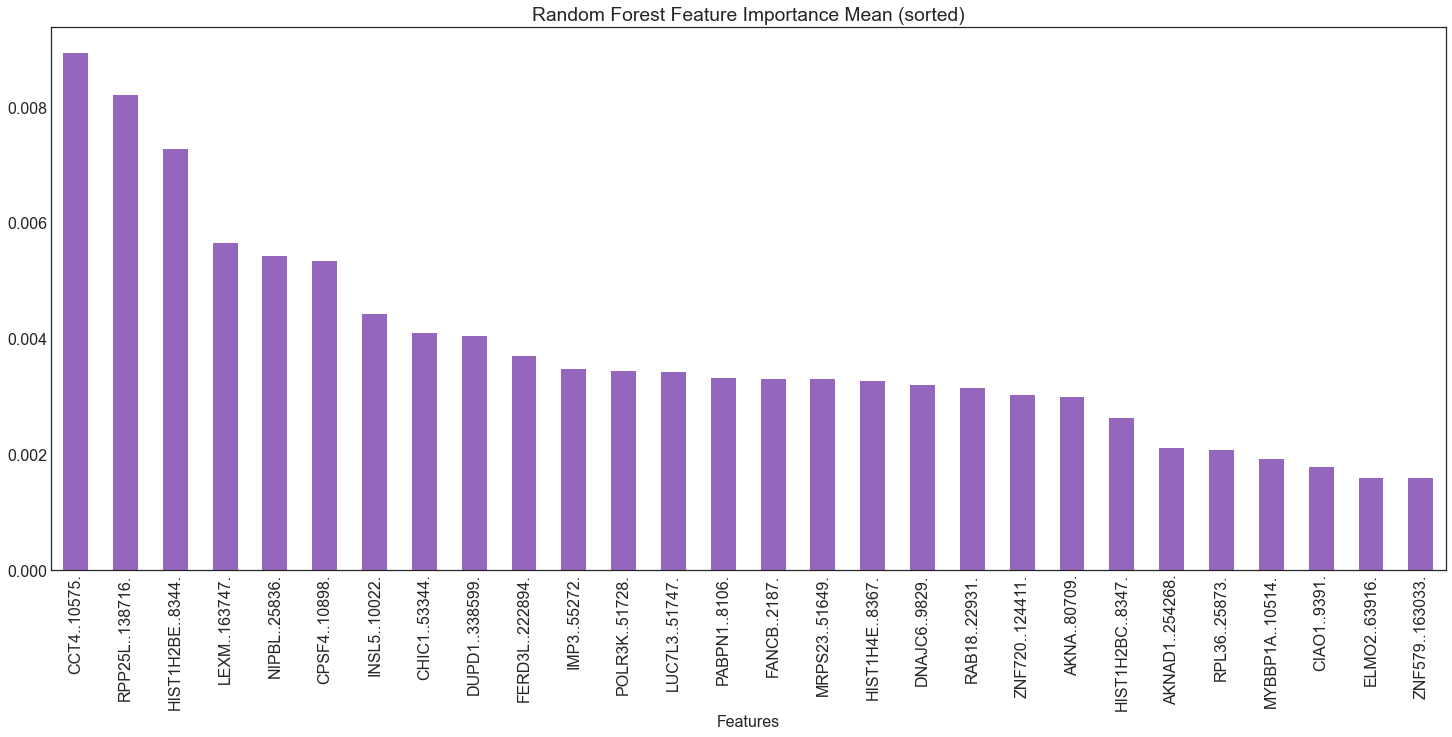

In [100]:
most_feat_impo = most_feat_impo.sort_values('Importance_mean', ascending = False)
most_feat_impo.Importance_mean.plot.bar(figsize = (25, 10), color = 'tab:purple')
plt.title('Random Forest Feature Importance Mean (sorted)')
plt.xlabel('Features')
plt.show()

This is a very poor result but it is in line with what said so far. Our RF classification for Lung Cancer has not provided any good results and indeed, the important features are few and with any significant percentage.

We do not try Boruta Algorithm because it is time consuming and probably we will not obtaing a relevant result.

Conclusion: it seems that detecting genes associated to Lung Cancer is a delicate study and we should need a priori biological knowledge in order to proceed with a better classification.